In [3]:
# pip install -U pandas torchvision mlflow lightning

In [4]:
# pip install git+https://github.com/pytorch/captum.git

In [6]:
import pandas as pd
import numpy as np
import torchvision
import torch
import random
import os 
import json
import matplotlib.pyplot as plt 
import mlflow
import seaborn as sns
import pickle 

from tqdm import tqdm
from pathlib import Path
from mouse_facial_expressions.paths import *
from mouse_facial_expressions.data.datasets import *
from mouse_facial_expressions.data.make_datasets import get_treatment_video_dataframe
from torch.utils.data import DataLoader
from sklearn.calibration import CalibratedClassifierCV


client = mlflow.MlflowClient('../mlruns')

EXPERIMENT_NAME = 'sex-differences'


SEED = 123456

In [3]:
def get_runs_by_dataset_version(experiment_name, version):
    experiment = client.search_experiments(filter_string=f"name='{experiment_name}'")[0]
    runs = client.search_runs(experiment_ids=experiment.experiment_id, order_by=["start_time"])
    filtered_runs = []
    for run in tqdm(runs):
        # Skip the main run
        parent = client.get_parent_run(run.info.run_id)
        if parent is None:
            continue
        
        # Skip runs with the wrong version
        if not run.data.params['dataset_version'] == version:
            continue

        filtered_runs.append(run)

    return filtered_runs


## Plotting Metrics

100%|██████████| 11/11 [00:00<00:00, 896.72it/s]

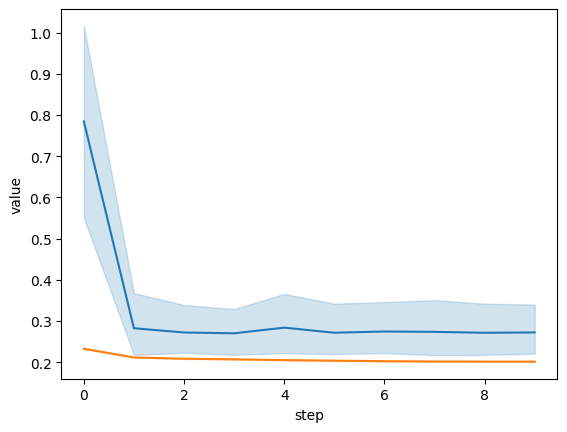

In [4]:
def make_metric_df(runs, metric):
    rows = []
    for run in runs:
        metric_history = client.get_metric_history(run.info.run_id, metric)
        rows += [{'value': x.value, 'step': x.step} for x in metric_history]
        
    return pd.DataFrame(rows)

# for version in ['1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7']:
#     runs = get_runs_by_dataset_version(experiment_name='baseline-v1.X', version=version)

for version in ['3.0']:
    runs = get_runs_by_dataset_version(experiment_name=EXPERIMENT_NAME, version=version)
    
    metric_df = make_metric_df(runs, 'val_loss')
    plt.figure()
    ax = plt.gca()
    sns.lineplot(data=metric_df, x='step', y='value', ax=ax)
    # plt.text(.99, .99, f"{metric_df[metric_df.step==9].value.mean():.2f}", ha='right', va='top', transform=ax.transAxes)
    
    metric_df = make_metric_df(runs, 'train_loss')
    sns.lineplot(data=metric_df, x='step', y='value', ax=ax)
    
    plt.show()

In [8]:
def get_model_from_run(run):
    artifact_folder = Path(run.info.artifact_uri.split('://')[-1])
    model_uri = artifact_folder / 'model'
    model = mlflow.pytorch.load_model(str(model_uri))
    return model

def get_meta_info(run):
    artifact_folder = Path(run.info.artifact_uri.split('://')[-1])
    meta_info_file = artifact_folder / 'meta_info/train_meta.json'
    with open(meta_info_file, 'r') as fp:
        meta_info = json.load(fp)

    return meta_info

def get_testable_mice(run):
    artifact_folder = Path(run.info.artifact_uri.split('://')[-1])
    testable_videos_mask = pd.read_csv(artifact_folder / 'testable_videos_mask/testable_videos_mask.csv', index_col=0)
    testable_mice = (testable_videos_mask==1).all(axis=1)
    return testable_mice[testable_mice].index.unique().to_list()

def get_trainable_mice(run):
    artifact_folder = Path(run.info.artifact_uri.split('://')[-1])
    testable_videos_mask = pd.read_csv(artifact_folder / 'testable_videos_mask/testable_videos_mask.csv', index_col=0)
    testable_mice = (testable_videos_mask==1).all(axis=1)
    return testable_mice[testable_mice==False].index.unique().to_list()

def get_evaluation_dataset(version):
    task_folder = get_task_folder(version=version)
    with open(task_folder / 'eval.pkl', 'rb') as fp:
        eval_dataset = pickle.load(fp)

    df = get_treatment_video_dataframe()
    eval_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
    
    dataset = Task1FoldDataset(samples=eval_dataset['eval'], df=df, transform=eval_transform)
    return dataset
    

In [11]:

SEED = 123456
results = []
for version in ['3.0']:
    runs = get_runs_by_dataset_version(experiment_name=EXPERIMENT_NAME, version=version)
    for run in tqdm(runs):
        try: 
            random.seed(SEED)
            np.random.seed(SEED)
            # torch.use_deterministic_algorithms(True)
            torch.manual_seed(SEED)
            model = get_model_from_run(run).to('cuda')

            test_mice = get_testable_mice(run)
            dataset = get_evaluation_dataset(version)
            dataloader = DataLoader(dataset, batch_size=100, num_workers=8)
            preds = []
            softmax_preds = []
            for batch in dataloader:
                x, y = batch
                x = x.to('cuda')
                with torch.no_grad():
                    pred = model(x)
                    softmax_pred = torch.nn.functional.softmax(pred, dim=1)
                    preds.append(pred.cpu().numpy())
                    softmax_preds.append(softmax_pred.cpu().numpy())

            preds = np.concatenate(preds)
            softmax_preds = np.concatenate(softmax_preds)

            result = pd.DataFrame()
            result[['s0', 's1']] = preds
            result[['p0', 'p1']] = softmax_preds
            result['sex'] = run.data.tags['sex']
            result['mouse'] = [dataset.df.loc[sample['indices']].mouse.unique()[0] for sample in dataset.samples]
            result['video'] = [dataset.df.loc[sample['indices']].video.unique()[0] for sample in dataset.samples]
            result['recording'] = [dataset.df.loc[sample['indices']].recording.unique()[0] for sample in dataset.samples]
            result['treatment'] = [dataset.df.loc[sample['indices']].treatment.unique()[0] for sample in dataset.samples]
            result['eval'] = result.mouse.apply(lambda x: x in test_mice)
            result['version'] = version

            # Create a calibrated model 
            # calibrated_model = CalibratedClassifierCV(model, cv=5, method='isotonic')
            # calibrated_model.fit(result['p1'], dataset.y)
            results.append(result)


        except Exception as e:
            print(f"Error in {run.info.run_id}")
    
    break

results = pd.concat(results)
# results = results.reset_index()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:56<00:00, 12.92s/it]

Error in 86ac542e436847f7b20ad1752a534928


In [45]:
results.treatment.value_counts()

treatment
saline                4000
high                  4000
mid                   3920
low                   3840
control               3600
control-acclimated    3600
Name: count, dtype: int64

In [54]:
final_accuracy = results['p1'].mean()

df =
for treatment in ['low', 'mid', 'high']:
    treatment_results = results[(results.treatment==treatment) & (results.recording == 4)]
    treatment_accuracy = (treatment_results['p1'] > 0.5).mean()
    print(f"The final model accuracy on the evaluation results for {treatment} is: {treatment_accuracy}")

    # report the CI interval
    n = len(treatment_results)
    p = treatment_accuracy
    ci = 1.96 * np.sqrt(p * (1-p) / n)
    print(f"The 95% CI is: {ci}")

    print(f"The 95% CI interval is: [{treatment_accuracy - ci}, {treatment_accuracy + ci}]")


for treatment in ['saline', 'control', 'control-acclimated']:
    treatment_results = results[(results.treatment==treatment) & (results.recording == 4)]
    treatment_accuracy = (treatment_results['p1'] > 0.5).mean()
    print(f"The final model accuracy on the evaluation results for {treatment} is: {treatment_accuracy}")

The final model accuracy on the evaluation results for low is: 0.2
The 95% CI is: 0.027718585822512666
The 95% CI interval is: [0.17228141417748735, 0.22771858582251267]
The final model accuracy on the evaluation results for mid is: 0.5725
The 95% CI is: 0.034282057807255385
The 95% CI interval is: [0.5382179421927447, 0.6067820578072554]
The final model accuracy on the evaluation results for high is: 0.9225
The 95% CI is: 0.01852870711895463
The 95% CI interval is: [0.9039712928810454, 0.9410287071189546]
The final model accuracy on the evaluation results for saline is: 0.14625
The final model accuracy on the evaluation results for control is: 0.35694444444444445
The final model accuracy on the evaluation results for control-acclimated is: 0.30972222222222223


In [62]:
# Rebase
temp = results[results['eval']]
temp = temp[temp.recording == 1]
temp = temp.groupby('mouse')['s1'].mean()
temp = temp.reset_index()

results['sbase'] = results.mouse.map(temp.set_index('mouse')['s1'])
results['s1_based'] = (results['s1'] - results['sbase'])

# Normalize 
results['s1_norm'] = (results['s1_based'] - results['s1_based'].min()) / (results['s1_based'].max() - results['s1_based'].min())
results

,s0,s1,p0,p1,sex,mouse,video,recording,treatment,eval,version,sbase,s1_based,s1_norm
0,3.313336,0.418750,0.947578,0.052422,male,f10,f10_rec0_acclimation,0,saline,True,3.0,0.389930,0.028820,0.300246
1,3.159919,0.437037,0.938363,0.061637,male,f10,f10_rec0_acclimation,0,saline,True,3.0,0.389930,0.047107,0.305695
2,3.449071,0.402571,0.954631,0.045369,male,f10,f10_rec0_acclimation,0,saline,True,3.0,0.389930,0.012641,0.295424
3,2.156334,0.556661,0.831973,0.168027,male,f10,f10_rec0_acclimation,0,saline,True,3.0,0.389930,0.166730,0.341343
4,3.170891,0.435729,0.939070,0.060930,male,f10,f10_rec0_acclimation,0,saline,True,3.0,0.389930,0.045799,0.305306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,-0.171331,0.929948,0.249500,0.750500,female,m9,m9_rec4_4h-postinjection,4,high,True,3.0,0.187553,0.742394,0.512888
2866,-3.287994,1.757111,0.006400,0.993600,female,m9,m9_rec4_4h-postinjection,4,high,True,3.0,0.187553,1.569558,0.759379
2867,-2.930940,1.662349,0.010018,0.989982,female,m9,m9_rec4_4h-postinjection,4,high,True,3.0,0.187553,1.474795,0.731141
2868,-1.546072,1.294804,0.055155,0.944845,female,m9,m9_rec4_4h-postinjection,4,high,True,3.0,0.187553,1.107251,0.621614


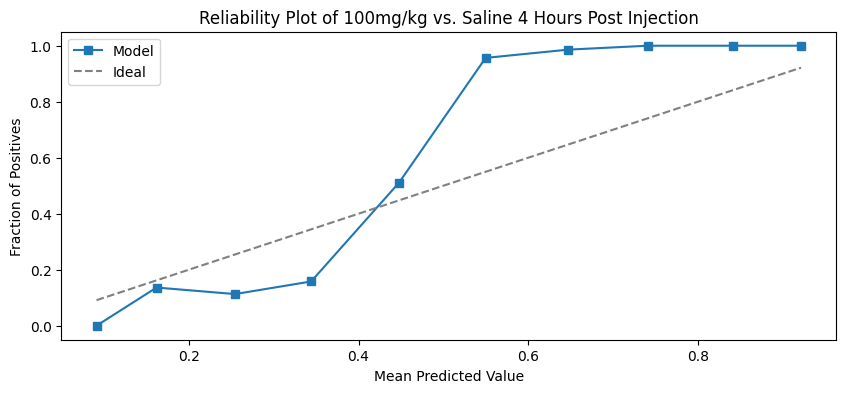

In [228]:
from sklearn.calibration import calibration_curve

temp = results[results['eval']==True]
temp = temp[temp.treatment.isin(['saline', 'high'])]
temp = temp[temp.recording.isin([4])]
temp = temp.copy()

temp['label'] = temp['treatment'].apply(lambda x: 1 if x=='high' else 0)

# Get the predicted probabilities and true labels


y_pred = temp['s1_norm']
y_true = temp['label']

# Compute the reliability curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10)

# Plot the reliability curve as a bar plot 
plt.figure(figsize=(10, 4))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model')

# Plot the ideal curve
xmin = mean_predicted_value.min()
xmax = mean_predicted_value.max()

plt.plot([xmin, xmax], [xmin, xmax], '--', color='gray', label='Ideal')

#
plt.legend()
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Plot of 100mg/kg vs. Saline 4 Hours Post Injection')
plt.savefig('reliability_plot.png', dpi=300)
plt.show()


In [10]:
for run in runs:
    print(run.data.tags['sex'])

male
male
male
male
female
female
female
female


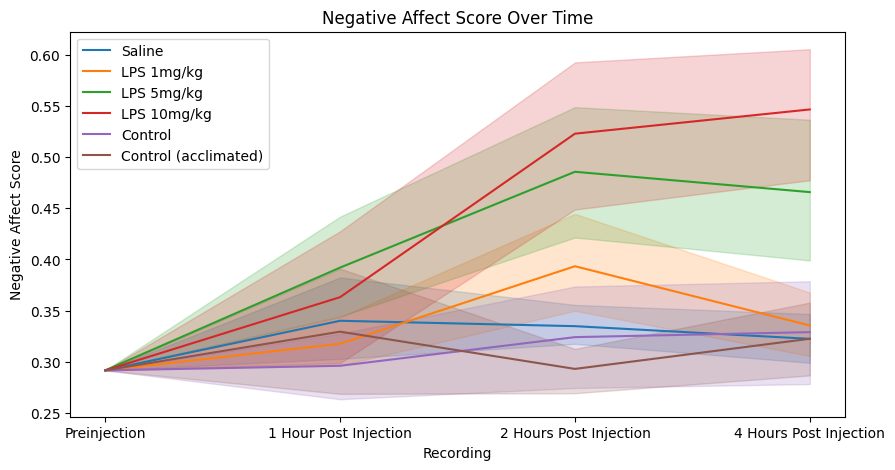

In [71]:
label_map = {
    'saline': 'Saline',
    'low': 'LPS 1mg/kg',
    'mid': 'LPS 5mg/kg',
    'high': 'LPS 10mg/kg',
    'control': 'Control',
    'control-acclimated': 'Control (acclimated)',
}

temp = results[results['eval']]
temp = temp[temp.recording > 0]
temp = temp[temp.treatment.isin(list(label_map.keys()))]
temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 's1_norm': 'mean', 'treatment': 'first'})

plt.figure(figsize=(10, 5))
sns.lineplot(data=temp, x='recording', y='s1_norm', hue='treatment', hue_order=list(label_map.keys()))

# Rename the legend 
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label_map[x] for x in labels]
plt.legend(handles, labels)

# Rename xticks 
plt.xticks([1,2,3,4], ['Preinjection', '1 Hour Post Injection', '2 Hours Post Injection', '4 Hours Post Injection'])

plt.xlabel('Recording')
plt.ylabel('Negative Affect Score')
plt.title('Negative Affect Score Over Time')

plt.savefig('score_gradients_all.png', dpi=300)



In [75]:
import statsmodels.stats.power as smp

# Define the parameters for the power analysis
effect_size = 0.5  # Expected effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Perform the power analysis
power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
# Print the results
print(f"Sample size needed: {sample_size}")


Sample size needed: 63.765611775409525


In [78]:

temp = results[results['eval'] & (results.sex == 'male') & (results.recording == 4) & (results.treatment == 'high')].groupby('mouse').agg({'s1_norm': 'mean'})
males = temp[temp.index.str.startswith('m')]
females = temp[temp.index.str.startswith('f')]



In [ ]:
import scipy.stats as stats

# Define the data for the two sexes

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(males, females)

# Compute the power
effect_size = abs(np.mean(males) - np.mean(females)) / np.sqrt((np.var(males) + np.var(females)) / 2)
power = stats.power_ttest_ind(effect_size=effect_size, nobs1=len(males), nobs2=len(females), alpha=0.05, alternative='two-sided')

power


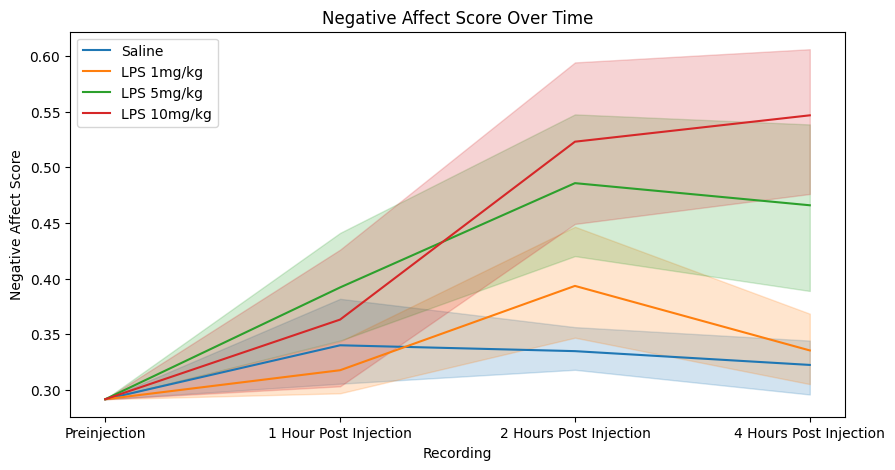

In [72]:
label_map = {
    # 'control': 'Control',
    # 'control-acclimated': 'Control (acclimated)',
    'saline': 'Saline',
    'low': 'LPS 1mg/kg',
    'mid': 'LPS 5mg/kg',
    'high': 'LPS 10mg/kg',
}

temp = results[results['eval']]
temp = temp[temp.recording > 0]
temp = temp[temp.treatment.isin(list(label_map.keys()))]
temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 's1_norm': 'mean', 'treatment': 'first'})

plt.figure(figsize=(10, 5))
sns.lineplot(data=temp, x='recording', y='s1_norm', hue='treatment', hue_order=list(label_map.keys()))

# Rename the legend 
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label_map[x] for x in labels]
plt.legend(handles, labels)

# Rename xticks 
plt.xticks([1,2,3,4], ['Preinjection', '1 Hour Post Injection', '2 Hours Post Injection', '4 Hours Post Injection'])

plt.xlabel('Recording')
plt.ylabel('Negative Affect Score')
plt.title('Negative Affect Score Over Time')

plt.savefig('score_gradients_on_the_same_day.png', dpi=300)



In [91]:
temp = results[results['eval']]
temp = temp[temp.recording > 0]
temp = temp[temp.treatment.isin(list(label_map.keys()))]
temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'}).reset_index()
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')

# temp.sex.value_counts()


,video,recording,s1,p1,treatment,sex
0,f10_rec1_preinjection,1,0.389930,0.200357,saline,female
1,f10_rec2_1h-postinjection,2,0.783066,0.557642,saline,female
2,f10_rec3_2h-postinjection,3,0.566910,0.360855,saline,female
3,f10_rec4_4h-postinjection,4,0.436437,0.226106,saline,female
4,f11_rec1_preinjection,1,0.465280,0.217767,low,female
...,...,...,...,...,...,...
143,m7_rec4_4h-postinjection,4,0.484219,0.288791,saline,male
144,m9_rec1_preinjection,1,0.187553,0.089697,high,male
145,m9_rec2_1h-postinjection,2,0.342241,0.184134,high,male
146,m9_rec3_2h-postinjection,3,1.279163,0.859185,high,male


In [59]:
label_map = {
    # 'control': 'Control',
    # 'control-acclimated': 'Control (acclimated)',
    'saline': 'Saline',
    'low': 'LPS 1mg/kg',
    'mid': 'LPS 5mg/kg',
    'high': 'LPS 10mg/kg',
}

temp = results[results['eval']]
temp = temp[temp.recording > 0]
temp = temp[temp.treatment.isin(list(label_map.keys()))]
temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 's1_based': 'mean', 'treatment': 'first', 'sex': 'first'}).reset_index()
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')

plt.figure(figsize=(10, 6))


plt.suptitle('Negative Affect Score Over Time in Males vs Females')

gs = plt.GridSpec(2, 1)

plt.subplot(gs[0])
sns.lineplot(data=temp[temp.sex == 'male'], x='recording', y='s1_based', hue='treatment', hue_order=list(label_map.keys()))

# Rename the legend 
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label_map[x] for x in labels]
plt.legend(handles, labels)

plt.ylabel('Male: Negative Affect Score')

# Hide xaxis
plt.xticks([])
plt.xlabel('')

plt.subplot(gs[1])
sns.lineplot(data=temp[temp.sex == 'female'], x='recording', y='s1_based', hue='treatment', hue_order=list(label_map.keys()))

# hide the legend 
plt.legend().remove()

# Rename xticks 
plt.xticks([1,2,3,4], ['Preinjection', '1 Hour Post Injection', '2 Hours Post Injection', '4 Hours Post Injection'])

plt.xlabel('Recording')
plt.ylabel('Female: Negative Affect Score')

plt.tight_layout()


plt.savefig('score_gradients_male_vs_female.png', dpi=300)



KeyError: "Column(s) ['s1_based'] do not exist"

In [154]:
import scipy.stats as stats
import pandas as pd
import pingouin as pg

# Assuming you have a DataFrame called 'data' with a column 'group' and a column 'value'
# 'group' represents the groups you want to compare, and 'value' represents the data

# Perform the Mann-Whitney U test between all pairs of groups
mannwhitneyu_results = pd.DataFrame()

label_map = {
    # 'control': 'Control',
    # 'control-acclimated': 'Control (acclimated)',
    'saline': 'Saline',
    'low': 'LPS 10mg/kg',
    'mid': 'LPS 50mg/kg',
    'high': 'LPS 100mg/kg',
}

sections = [
    'Preinjection',
    '1 Hour Post Injection',
    '2 Hours Post Injection',
    '4 Hours Post Injection',
][::-1]

for r, recording in enumerate([4,3,2,1]):
    temp = results[results['eval']]
    temp = temp[temp.recording == recording]
    temp = temp[temp.treatment.isin(list(label_map.keys()))]
    temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'}).reset_index()
    temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
    # temp = temp[temp.sex == 'male']

    # Kruskal Wallis test
    kruskal_results = pg.kruskal(data=temp, dv='p1', between='treatment')
    print(kruskal_results)

    groups = list(label_map.keys())
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            group1_data = temp[temp.treatment == group1]['p1'] 
            group2_data = temp[temp.treatment == group2]['p1'] 
            stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
            mannwhitneyu_results.loc[label_map[group1], label_map[group2]] = p_value

    print(f"\subsubsection*{{{sections[r]}}}")
    print(mannwhitneyu_results.fillna('').to_latex(float_format="%.4f"))



            Source  ddof1          H     p-unc
Kruskal  treatment      3  16.835941  0.000764
\subsubsection*{4 Hours Post Injection}
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midrule
Saline & 0.8286 & 0.0128 & 0.0013 \\
LPS 10mg/kg &  & 0.0745 & 0.0014 \\
LPS 50mg/kg &  &  & 0.0792 \\
\bottomrule
\end{tabular}

            Source  ddof1          H     p-unc
Kruskal  treatment      3  12.384661  0.006175
\subsubsection*{2 Hours Post Injection}
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midrule
Saline & 0.1220 & 0.0080 & 0.0046 \\
LPS 10mg/kg &  & 0.1996 & 0.0676 \\
LPS 50mg/kg &  &  & 0.4877 \\
\bottomrule
\end{tabular}

            Source  ddof1         H     p-unc
Kruskal  treatment      3  0.953651  0.812465
\subsubsection*{1 Hour Post Injection}
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midrule
Saline & 0.9654 & 0.7133 & 0.9097 \\
LPS 10mg/kg &  & 0.3213 & 0.8286 \\
LPS 50m

## Normalize by Animal

In [234]:
import scipy.stats as stats
import pandas as pd
import pingouin as pg

# Assuming you have a DataFrame called 'data' with a column 'group' and a column 'value'
# 'group' represents the groups you want to compare, and 'value' represents the data

# Perform the Mann-Whitney U test between all pairs of groups
mannwhitneyu_results = pd.DataFrame()


temp = results[results['eval']]
temp = temp[temp.recording == 1]
temp = temp.groupby('mouse')['p1'].mean()
temp = temp.reset_index()

results['pbase'] = results.mouse.map(temp.set_index('mouse')['p1'])
results['p1_based'] = results['p1'] - results['pbase']


label_map = {
    # 'control': 'Control',
    # 'control-acclimated': 'Control (acclimated)',
    'saline': 'Saline',
    'low': 'LPS 10mg/kg',
    'mid': 'LPS 50mg/kg',
    'high': 'LPS 100mg/kg',
}

sections = [
    'Preinjection',
    '1 Hour Post Injection',
    '2 Hours Post Injection',
    '4 Hours Post Injection',
][::-1]

for r, recording in enumerate([4,3,2,1]):
    temp = results[results['eval']]
    temp = temp[temp.recording == recording]
    temp = temp[temp.treatment.isin(list(label_map.keys()))]
    temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 's1_based': 'mean', 'treatment': 'first', 'sex': 'first'}).reset_index()
    temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
    # temp = temp[temp.sex == 'male']

    # Kruskal Wallis test
    kruskal_results = pg.kruskal(data=temp, dv='s1_based', between='treatment')


    print(f"\subsubsection*{{{sections[r]}}}")
    print(f"Kruskal Wallis (p={kruskal_results['p-unc'].values[0]:.04f}) \\\\")
    
    groups = list(label_map.keys())
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            group1_data = temp[temp.treatment == group1]['s1_based'] 
            group2_data = temp[temp.treatment == group2]['s1_based'] 
            stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
            mannwhitneyu_results.loc[label_map[group1], label_map[group2]] = p_value

    print(mannwhitneyu_results.fillna('').to_latex(float_format="%.4f"))



\subsubsection*{4 Hours Post Injection}
Kruskal Wallis (p=0.0002) \\
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midrule
Saline & 0.6965 & 0.0080 & 0.0004 \\
LPS 10mg/kg &  & 0.0274 & 0.0003 \\
LPS 50mg/kg &  &  & 0.1779 \\
\bottomrule
\end{tabular}

\subsubsection*{2 Hours Post Injection}
Kruskal Wallis (p=0.0010) \\
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midrule
Saline & 0.1011 & 0.0037 & 0.0008 \\
LPS 10mg/kg &  & 0.0592 & 0.0434 \\
LPS 50mg/kg &  &  & 0.4877 \\
\bottomrule
\end{tabular}

\subsubsection*{1 Hour Post Injection}
Kruskal Wallis (p=0.1973) \\
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midrule
Saline & 0.6965 & 0.1530 & 0.4727 \\
LPS 10mg/kg &  & 0.0360 & 0.2743 \\
LPS 50mg/kg &  &  & 0.4379 \\
\bottomrule
\end{tabular}

\subsubsection*{Preinjection}
Kruskal Wallis (p=0.2229) \\
\begin{tabular}{lllr}
\toprule
 & LPS 10mg/kg & LPS 50mg/kg & LPS 100mg/kg \\
\midru

In [ ]:
import scipy.stats as stats
import pandas as pd
import pingouin as pg

# Assuming you have a DataFrame called 'data' with a column 'group' and a column 'value'
# 'group' represents the groups you want to compare, and 'value' represents the data

# Perform the Mann-Whitney U test between all pairs of groups
mannwhitneyu_results = pd.DataFrame()

label_map = {
    'saline': 'Saline',
    'low': 'LPS 10mg/kg',
    'mid': 'LPS 50mg/kg',
    'high': 'LPS 100mg/kg',
}
temp = results[results['eval']]
temp = temp[temp.recording > 0]
temp = temp[temp.treatment.isin(list(label_map.keys()))]
temp = temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'}).reset_index()
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')


groups = ['saline', 'low', 'mid', 'high']
for i in range(len(groups)):
    for j in range(len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        group1_data = temp[temp.treatment == group1]['p1']
        group2_data = temp[temp.treatment == group2]['p1']
        stat, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        mannwhitneyu_results.loc[group1, group2] = p_value

mannwhitneyu_results


<Axes: xlabel='recording', ylabel='s1_based'>

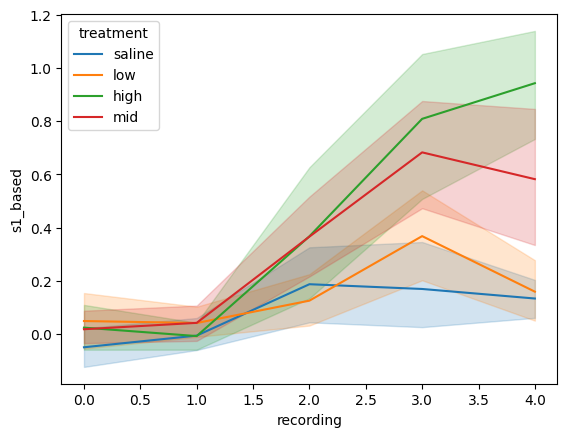

In [236]:
temp = results[results['eval'] & (results['sex']=='male')]
temp = temp[temp.treatment.isin(['saline', 'low', 'mid', 'high'])]
temp = temp.groupby('video').agg({'recording': 'first', 's1_based': 'mean', 'p1': 'mean', 'treatment': 'first'})
sns.lineplot(data=temp, x='recording', y='s1_based', hue='treatment')

<Axes: xlabel='recording', ylabel='s1_based'>

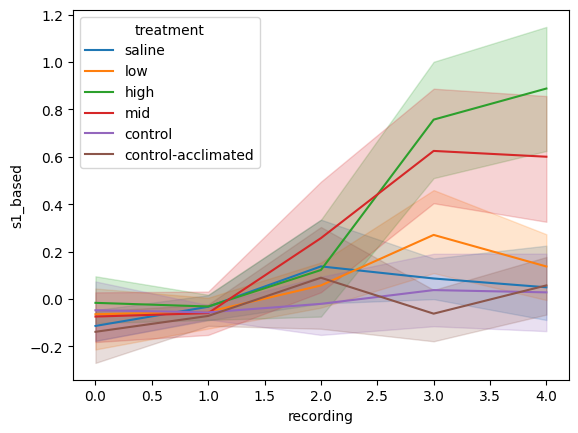

In [237]:
temp = results[results['eval'] & (results['sex']=='female')]
temp = temp.groupby('video').agg({'recording': 'first', 's1_based': 'mean', 'p1': 'mean', 'treatment': 'first'})
sns.lineplot(data=temp, x='recording', y='s1_based', hue='treatment')

In [49]:
temp.video

100         f12_rec0_acclimation
101         f12_rec0_acclimation
102         f12_rec0_acclimation
103         f12_rec0_acclimation
104         f12_rec0_acclimation
                  ...           
2865    m9_rec4_4h-postinjection
2866    m9_rec4_4h-postinjection
2867    m9_rec4_4h-postinjection
2868    m9_rec4_4h-postinjection
2869    m9_rec4_4h-postinjection
Name: video, Length: 1850, dtype: object

In [50]:
temp = results[results['eval'] & (results['treatment']=='high')]
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'})

/tmp/ipykernel_1451121/3587853962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')


,recording,s1,p1,treatment,sex
video,,,,,
f12_rec0_acclimation,0,0.327323,0.121879,high,female
f12_rec1_preinjection,1,0.303628,0.100454,high,female
f12_rec2_1h-postinjection,2,0.848839,0.631822,high,female
f12_rec3_2h-postinjection,3,1.224116,0.921159,high,female
f12_rec4_4h-postinjection,4,1.594777,0.992333,high,female
f15_rec0_acclimation,0,0.120947,0.050989,high,female
f15_rec1_preinjection,1,0.135058,0.054433,high,female
f15_rec2_1h-postinjection,2,0.217249,0.082934,high,female
f15_rec3_2h-postinjection,3,0.337169,0.159169,high,female


/tmp/ipykernel_1451121/317686006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')


<Axes: xlabel='recording', ylabel='p1'>

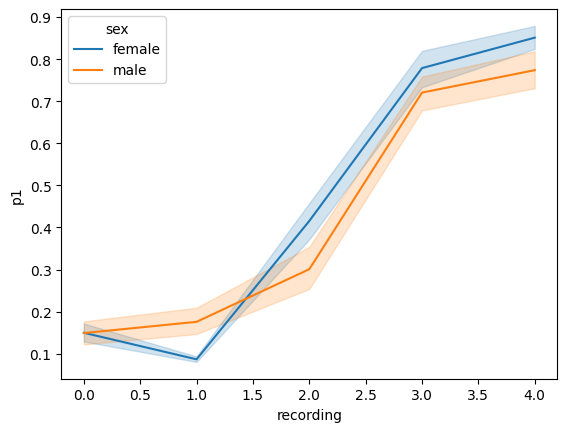

In [65]:
temp = results[results['eval'] & (results['treatment'].isin(['high']))]
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'})
sns.lineplot(data=temp, x='recording', y='p1', hue='sex')

/tmp/ipykernel_1451121/1498199145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')


<Axes: xlabel='recording', ylabel='p1'>

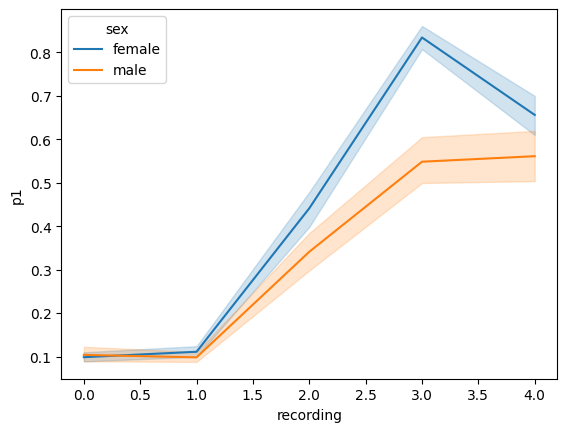

In [86]:
temp = results[results['eval'] & (results['treatment'].isin(['mid']))]
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'})
sns.lineplot(data=temp, x='recording', y='p1', hue='sex')

/tmp/ipykernel_1451121/3470471416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')


<Axes: xlabel='recording', ylabel='p1'>

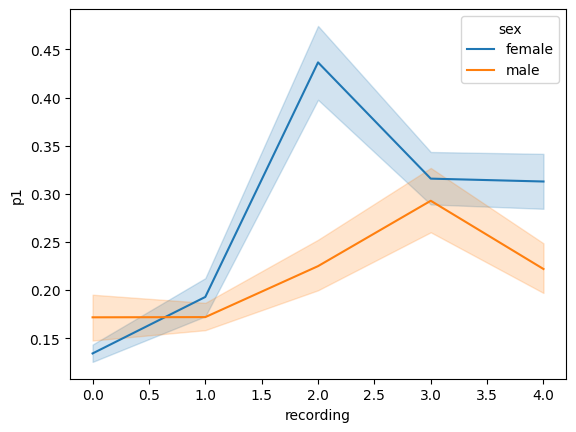

In [63]:
temp = results[results['eval'] & (results['treatment'].isin(['saline']))]
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'})
sns.lineplot(data=temp, x='recording', y='p1', hue='sex')

/tmp/ipykernel_1451121/1156826310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')


<Axes: xlabel='recording', ylabel='p1'>

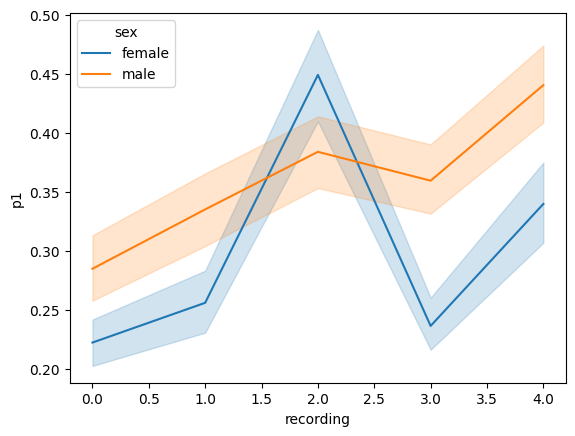

In [88]:
temp = results[results['eval'] & (results['treatment'].isin(['control-acclimated']))]
temp['sex'] = temp.video.apply(lambda x: 'male' if x.startswith('m') else 'female')
temp.groupby('video').agg({'recording': 'first', 's1': 'mean', 'p1': 'mean', 'treatment': 'first', 'sex': 'first'})
sns.lineplot(data=temp, x='recording', y='p1', hue='sex')

## Occlusion Explainability

In [71]:
x, y = dataset[i]
x[0].shape

torch.Size([3, 300, 300])

  0%|          | 0/9 [00:00<?, ?it/s]

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


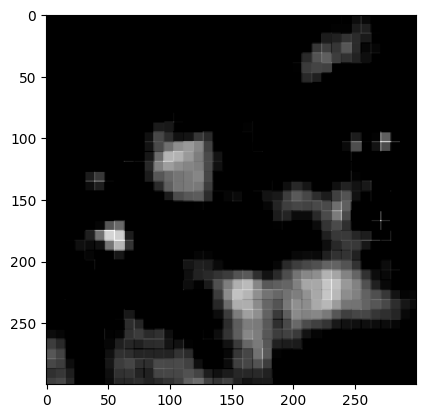

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


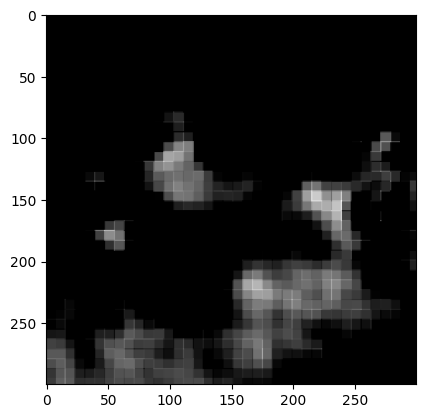

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


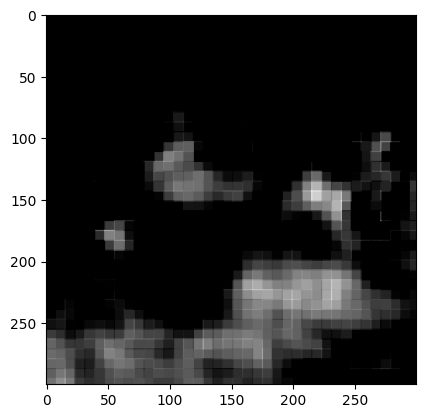

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


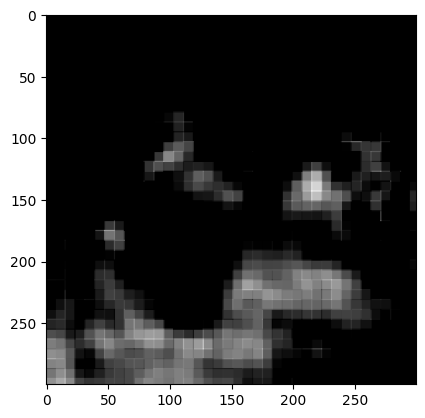

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


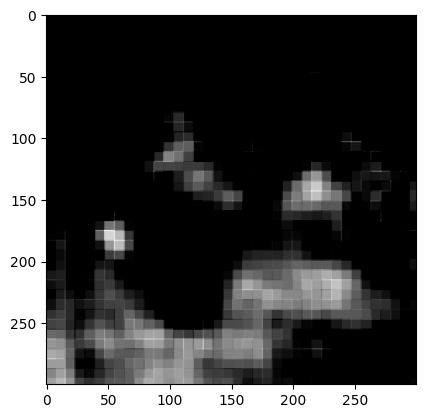

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


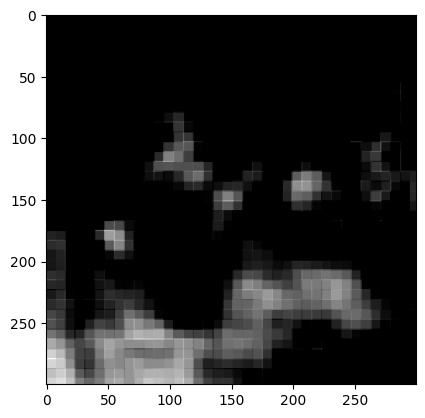

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


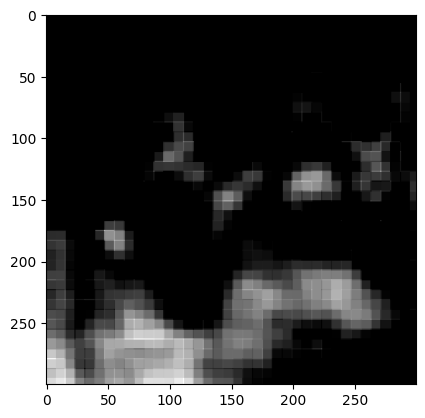

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


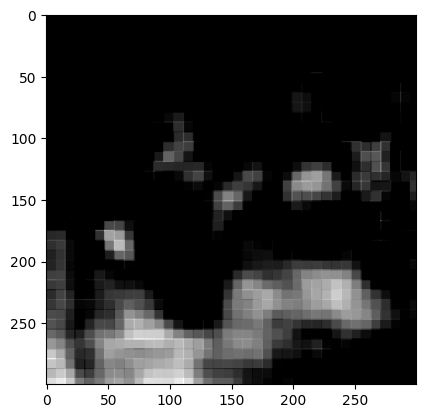

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


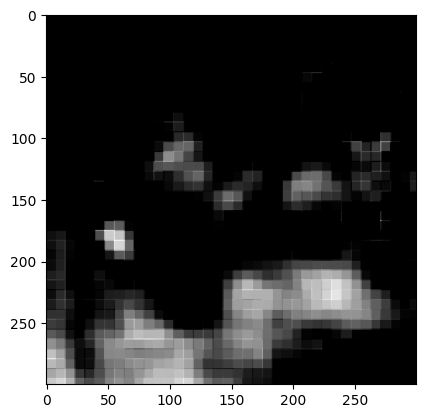

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


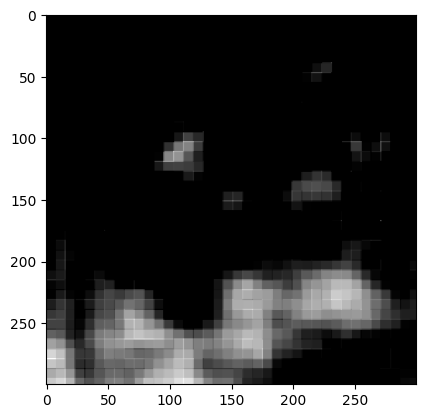

In [48]:
import captum
from IPython.display import display
from pathlib import Path

MAKE_PLOTS = False

figures_path = Path('.').resolve().parent / 'reports' / '20230803-noaug'
if not figures_path.exists():
    figures_path.mkdir(parents=True)

for version in ['3.0']:
    runs = get_runs_by_dataset_version(experiment_name=EXPERIMENT_NAME, version=version)

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    np.random.shuffle(runs)
    for run in tqdm(runs):
        test_mice = get_testable_mice(run)
        model = get_model_from_run(run).to('cuda')

        if run.data.tags['sex'] == 'female':
            break 

occlusion = captum.attr.Occlusion(model)

np.random.seed(42)
indices = results[(results['eval']) & (results.treatment=='high')&(results.recording.isin([1]))].index
average_results = dict()

images = []

for i in np.random.choice(indices, size=10):
    x, y = dataset[i]
    x = x[0]
    # target = y
    target = 1
    # target = model(x)
    print('---')
    print('label', y)
    # display(torchvision.transforms.ToPILImage()(x))
    images.append(torchvision.transforms.ToPILImage()(x))
    x = x.to('cuda')
    row = results.loc[i].iloc[0]

    for label in ['negative']:
        attributions_occ = occlusion.attribute(
            x.unsqueeze(0).unsqueeze(0).to('cuda'),
            strides = (1, 3, 8, 8),
            target=1,
            sliding_window_shapes=(1,3,15, 15),
            baselines=0)

        attributions_occ = attributions_occ.squeeze().squeeze().cpu().detach().numpy()
        attributions_occ = attributions_occ / attributions_occ.max()

        if not f"{label}_small" in average_results:
            average_results[f"{label}_small"] = [attributions_occ]
        else:
            average_results[f"{label}_small"].append(attributions_occ)
            

    plt.figure()
    occ = np.stack(average_results['negative_small'])
    # occ *= -1 

    occ = occ.mean(axis=0).transpose(1,2,0)
    occ = occ / occ.max()
    print(occ.shape)     
    female_occ = occ.copy()                          
    plt.imshow(occ)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


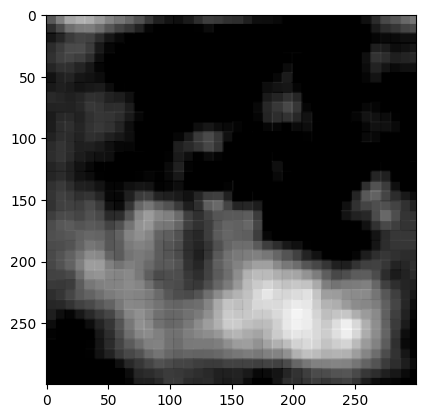

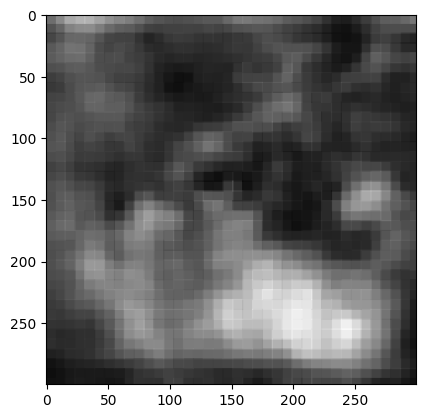

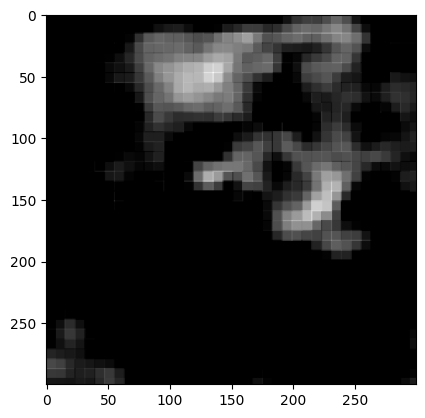

In [30]:
plt.figure()
occ = np.stack(average_results['negative_small']).mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

plt.figure()
occ = np.stack(average_results['negative_small'])
occ[occ<0] = 0
occ = occ.mean(axis=0).transpose(1,2,0)
occ = np.abs(occ)

plt.imshow(occ / occ.max())


plt.figure()
occ = np.stack(average_results['negative_small'])
occ *= -1 

occ = occ.mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 31.11it/s]


---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


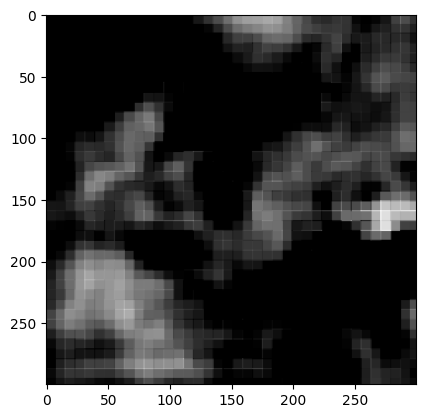

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


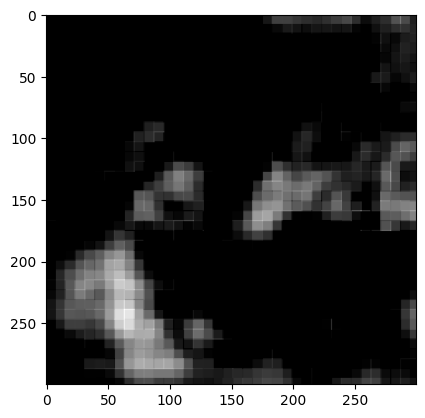

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


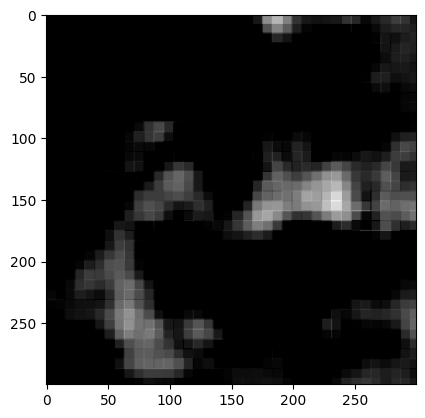

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


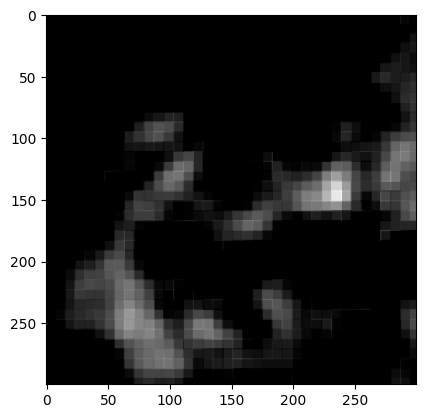

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


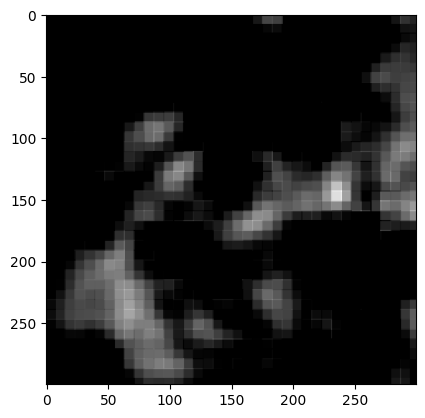

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


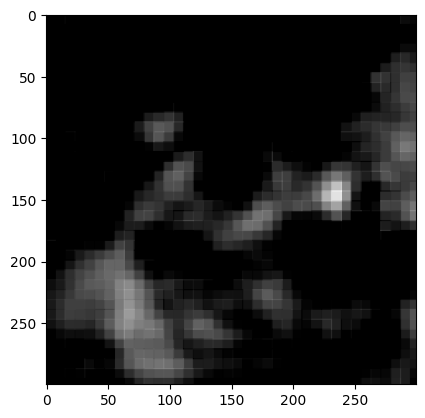

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


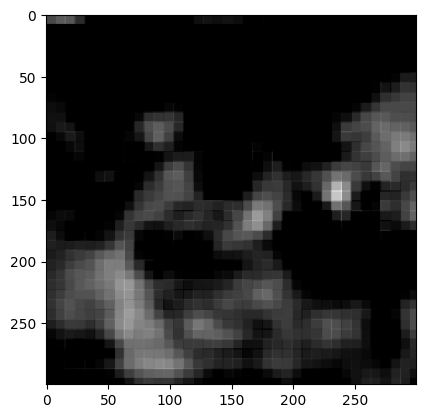

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


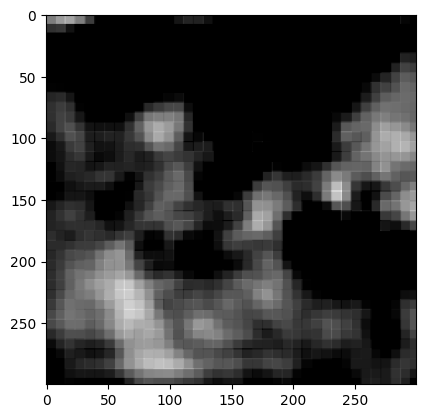

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


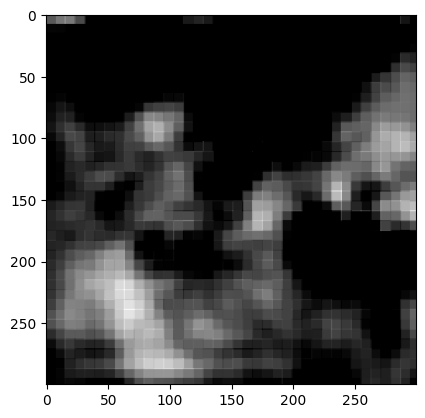

---
label -1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


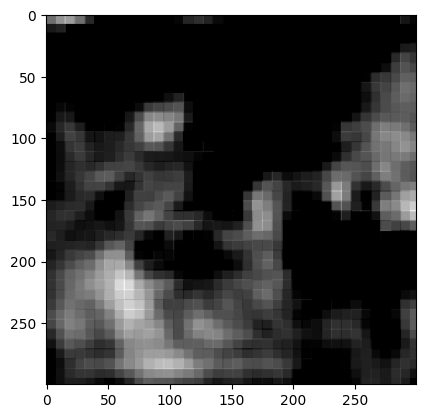

In [45]:
import captum
from IPython.display import display
from pathlib import Path

MAKE_PLOTS = False

figures_path = Path('.').resolve().parent / 'reports' / '20230803-noaug'
if not figures_path.exists():
    figures_path.mkdir(parents=True)

for version in ['3.0']:
    runs = get_runs_by_dataset_version(experiment_name=EXPERIMENT_NAME, version=version)

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    np.random.shuffle(runs)
    for run in tqdm(runs):
        test_mice = get_testable_mice(run)
        model = get_model_from_run(run).to('cuda')

        if run.data.tags['sex'] == 'male':
            break 

occlusion = captum.attr.Occlusion(model)

np.random.seed(42)
indices = results[(results['eval']) & (results.treatment=='high')&(results.recording.isin([1]))].index
average_results = dict()

images = []

for i in np.random.choice(indices, size=10):
    x, y = dataset[i]
    x = x[0]
    # target = y
    target = 1
    # target = model(x)
    print('---')
    print('label', y)
    # display(torchvision.transforms.ToPILImage()(x))
    images.append(torchvision.transforms.ToPILImage()(x))
    x = x.to('cuda')
    row = results.loc[i].iloc[0]

    for label in ['negative']:
        attributions_occ = occlusion.attribute(
            x.unsqueeze(0).unsqueeze(0).to('cuda'),
            strides = (1, 3, 8, 8),
            target=-1,
            sliding_window_shapes=(1,3,15, 15),
            baselines=0)

        attributions_occ = attributions_occ.squeeze().squeeze().cpu().detach().numpy()
        # attributions_occ = attributions_occ / attributions_occ.max()

        if not f"{label}_small" in average_results:
            average_results[f"{label}_small"] = [attributions_occ]
        else:
            average_results[f"{label}_small"].append(attributions_occ)
            

    plt.figure()
    occ = np.stack(average_results['negative_small'])
    # occ *= -1 

    occ = occ.mean(axis=0).transpose(1,2,0)
    occ = occ / occ.max()
    print(occ.shape)     
    male_occ = occ.copy()                          
    plt.imshow(occ)
    plt.show()

In [49]:
import captum
from IPython.display import display
from pathlib import Path

MAKE_PLOTS = False

figures_path = Path('.').resolve().parent / 'reports' / '20230803-noaug'
if not figures_path.exists():
    figures_path.mkdir(parents=True)

for version in ['3.0']:
    runs = get_runs_by_dataset_version(experiment_name=EXPERIMENT_NAME, version=version)
    np.random.shuffle(runs)
    for run in tqdm(runs):
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)

        dataset = get_evaluation_dataset(version)

        test_mice = get_testable_mice(run)
        model = get_model_from_run(run).to('cuda')

        if run.data.tags['sex'] == 'female':
            break 
 
occlusion = captum.attr.Occlusion(model)

np.random.seed(42)
indices = results[(results.treatment=='high')&(results.recording.isin([1,4]))&(results['eval'])].index
average_results = dict()

for i in np.random.choice(indices, size=10):
    x, y = dataset[i]
    x = x[0]
    target = y
    # target = model(x)
    print('---')
    print('label', y)
    # display(torchvision.transforms.ToPILImage()(x))
    x = x.to('cuda')
    row = results.loc[i].iloc[0]

    for label in ['positive', 'negative']:
        try:
            attributions_occ = occlusion.attribute(
                x.unsqueeze(0).unsqueeze(0).to('cuda'),
                strides = (1, 3, 8, 8),
                target=y,
                sliding_window_shapes=(1,3,15, 15),
                baselines=0)

            attributions_occ = attributions_occ.squeeze().squeeze().cpu().detach().numpy()
            if not f"{label}_small" in average_results:
                average_results[f"{label}_small"] = [attributions_occ]
            else:
                average_results[f"{label}_small"].append(attributions_occ)
                
            if MAKE_PLOTS:
                fig, ax = captum.attr.visualization.visualize_image_attr_multiple(
                    np.transpose(attributions_occ, (1,2,0)),
                    np.transpose(x.cpu().detach().numpy(), (1,2,0)),
                    ["original_image", "heat_map"],
                    ["all", label],
                    show_colorbar=True,
                    outlier_perc=1,
                    use_pyplot=True
                    )
            
                fig.savefig(figures_path / f"{row.video}_sample{i:05}_small_{label}.png")
                fig.savefig(figures_path / f"{row.video}_sample{i:05}_small_{label}.pdf")
            
            attributions_occ = occlusion.attribute(
                x.unsqueeze(0).unsqueeze(0).to('cuda'),
                strides = (1, 3, 50, 50),
                target=y,
                sliding_window_shapes=(1,3,100,100),
                baselines=0)

            attributions_occ = attributions_occ.squeeze().squeeze().cpu().detach().numpy()
            if not f"{label}_large" in average_results:
                average_results[f"{label}_large"] = [attributions_occ]
            else:
                average_results[f"{label}_large"].append(attributions_occ)

            if MAKE_PLOTS:
                fig, ax = captum.attr.visualization.visualize_image_attr_multiple(
                    np.transpose(attributions_occ, (1,2,0)),
                    np.transpose(x.cpu().detach().numpy(), (1,2,0)),
                    ["original_image", "heat_map"],
                    ["all", label],
                    show_colorbar=True,
                    outlier_perc=1,
                    use_pyplot=True
                    )
                
                fig.savefig(figures_path / f"{row.video}_sample{i:05}_large_{label}.png")
                fig.savefig(figures_path / f"{row.video}_sample{i:05}_large_{label}.pdf")
        except:
            pass

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:01<00:04,  1.66it/s]


---
label -1
---
label -1
---
label -1
---
label -1
---
label -1
---
label -1
---
label -1
---
label -1
---
label -1
---
label -1


In [12]:
plt.figure()
occ = np.stack(average_results['positive_small']).mean(axis=0).transpose(1,2,0)
plt.imshow(np.abs(occ) / occ.max())

plt.figure()
occ = np.stack(average_results['positive_small']).mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

plt.figure()
occ = np.stack(average_results['positive_small']).mean(axis=0)
occ += np.stack(average_results['negative_small']).mean(axis=0)
occ = occ.transpose(1,2,0)
male_occ = occ.copy() / occ.max()
plt.imshow(occ / occ.max())

plt.figure()
occ = np.stack(average_results['negative_small'])
occ[occ<0] = 0
occ = occ.mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

plt.figure()
occ = np.stack(average_results['positive_large']).mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

plt.figure()
occ = np.stack(average_results['negative_large']).mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

NameError: name 'average_results' is not defined

<Figure size 640x480 with 0 Axes>

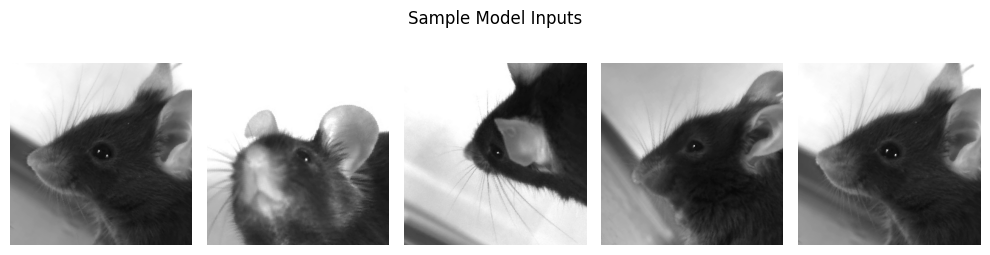

In [58]:
plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 5)

for i in range(5):
    plt.subplot(gs[i])
    plt.imshow(images[i])
    plt.axis('off')
    
plt.tight_layout()
plt.suptitle('Sample Model Inputs')
plt.savefig('sample_images.png', dpi=300)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


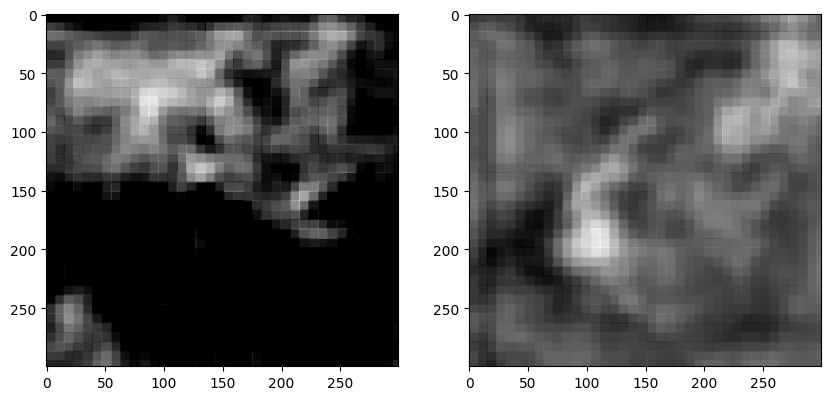

In [37]:
plt.figure(figsize=(10, 5))
gs = plt.GridSpec(1, 2)

plt.subplot(gs[0])
plt.imshow(male_occ / male_occ.max())

plt.subplot(gs[1])
plt.imshow(female_occ / female_occ.max())  


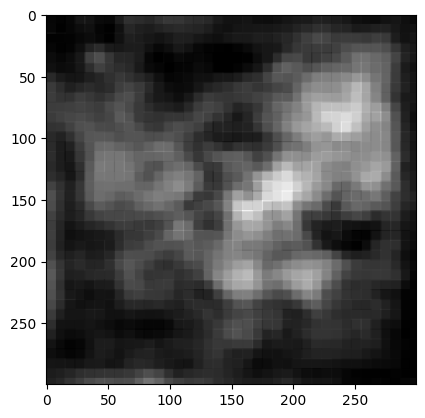

In [16]:
occ = np.stack(average_results['negative_small'])
occ[occ<0] = 0
occ = occ.mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

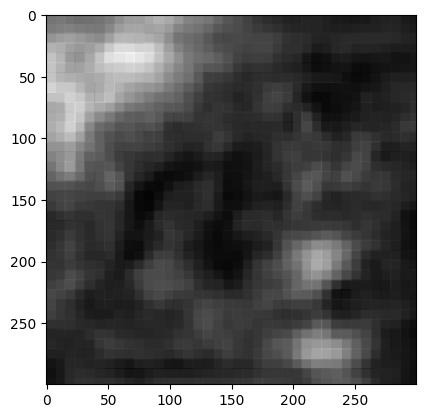

In [36]:
occ = np.stack(average_results['negative_small'])
occ[occ>0] = 0
occ = np.abs(occ)
occ = occ.mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


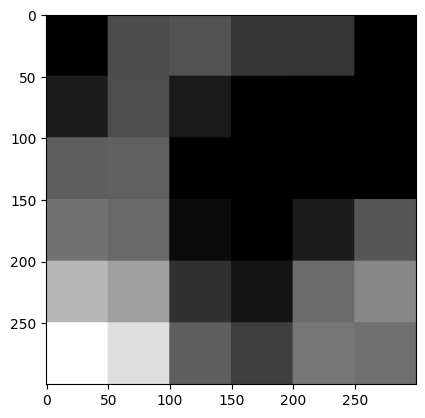

In [12]:
occ = np.stack(average_results['positive_large']).mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


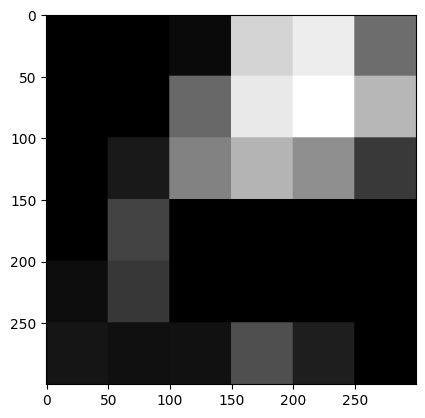

In [38]:
occ = np.stack(average_results['negative_large']).mean(axis=0).transpose(1,2,0)
plt.imshow(occ / occ.max())